In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import glob
import scipy as sc

In [2]:
def extract_date(date):
    path = './sequence_data/'

    filepath = path + date + '/more_' + date + '.mat'
    # Extract data
    try:
        data = {}
        f = h5py.File(filepath)
        for k, v in f.items():
            data[k] = np.array(v)
        f.close()
    except:
        data = sc.io.loadmat(filepath)

    return data
    
path = './sequence_data/'
filenames = glob.glob(path + '*')
dates = []
for filename in filenames:
    date = filename[len(path):]
    if date[:4] == '2019':
        dates.append(date)

dates = np.sort(dates)
dates

array(['20190828', '20190831', '20190901', '20190903', '20190904',
       '20190905', '20190909', '20190910', '20190911', '20190912',
       '20190915', '20190916', '20190917', '20190918', '20190920',
       '20190921', '20190922', '20190924', '20190925', '20190926'],
      dtype='<U8')

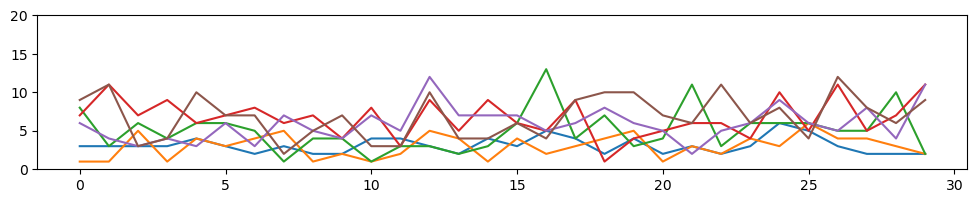

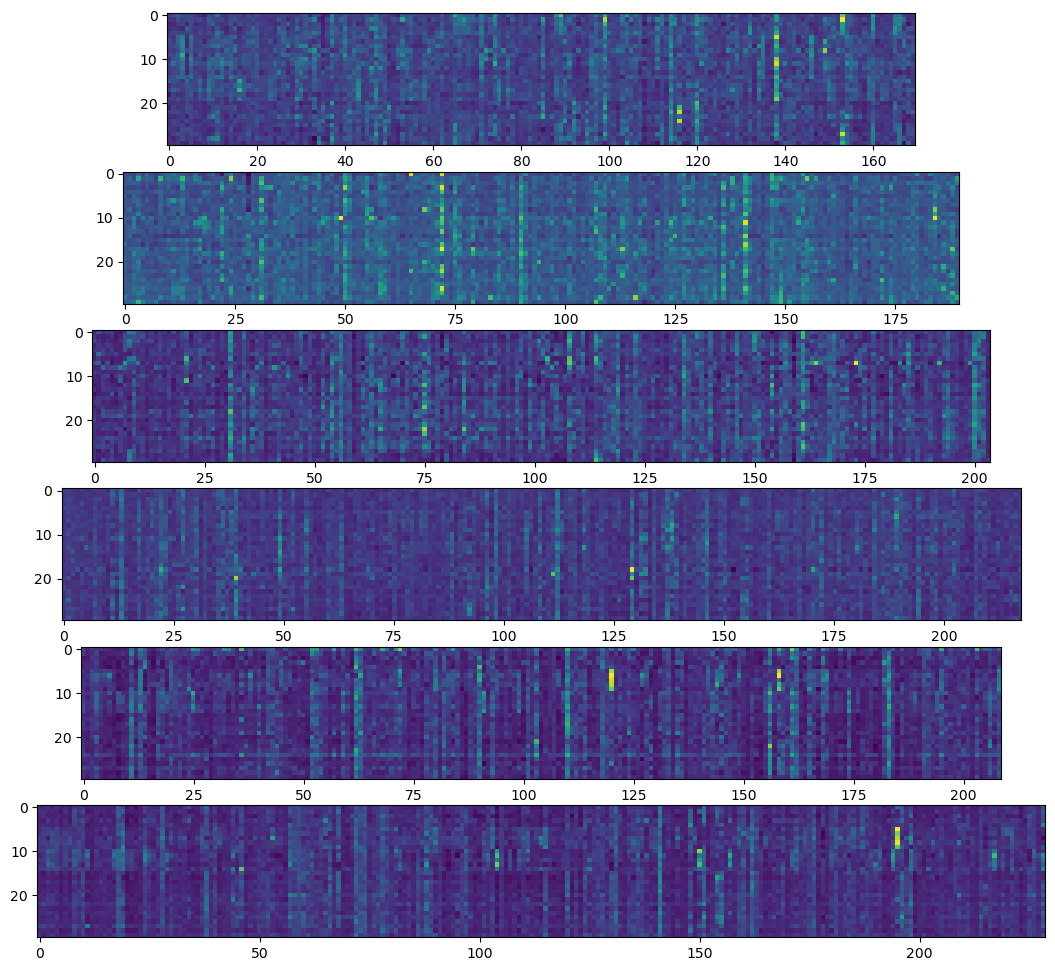

In [6]:
# Go through and extract all the neural representations of all 30 trials
# Choose between extracting all the ones with all length one or two sequences
avg_neur_resps_all = []
total_num_neurons = 0
plt.figure(figsize = (12, 2))
num_full = 0
num_seqs_full = 30

for date_ind, date in enumerate(dates):
    # Load this data
    data = extract_date(date)
    
    # Extract the relevant parts
    targets_presented = data['targets']
    matches = data['matches']
    behavioural_responses = data['response']
    neural_response = data['F_']
    frame_ids = data['frameid']
    cue_on_frames = data['cue_on']
    frame_rate = data['fr'][0][0]
    
    # Let's rotate things when needed (the way the data is stored changes each time)
    if targets_presented.shape[0] < targets_presented.shape[1]:
        targets_presented = targets_presented.T
        neural_response = neural_response.T
        matches = matches[:,0]
        cue_on_frames = cue_on_frames[:,0]
        frame_ids = frame_ids.T
    else:
        matches = matches[0,:]
        cue_on_frames = cue_on_frames[0,:]

    # And define some numbers of things from these
    num_trials_upper_bound = sum(matches)
    num_trials = targets_presented.shape[0]
    num_neurons, num_frames = neural_response.shape
    delay_period_length = int(np.ceil(1*frame_rate))
    
    # Let's go through and find all the correct two sequence trials, then focus on those bits of the data
    correct_len_seq_trials = np.sum(targets_presented != 0, axis = 1) == 2
    correct_len_seq_correct_trials = np.logical_and(correct_len_seq_trials, matches == 1)
    targets_presented = targets_presented[correct_len_seq_correct_trials,:2]
    frame_ids = frame_ids[correct_len_seq_correct_trials,:]
    cue_on_frames = cue_on_frames[correct_len_seq_correct_trials]
    correct_unique_seqs = np.unique(targets_presented, axis = 0)

    if correct_unique_seqs.shape[0] == 30:
        num_full += 1
        
        # Then go through and extract relevant trials
        num_per_seq = np.zeros([num_seqs_full])
        avg_seq_reps = np.zeros([num_neurons, num_seqs_full])
        for seq_ind, seq in enumerate(correct_unique_seqs):
            trial_this_seq = np.all(targets_presented == seq, axis = 1)
            num_per_seq[seq_ind] = np.sum(trial_this_seq)
        
            averaging_end_times = cue_on_frames[trial_this_seq] + frame_ids[trial_this_seq,4]
            averaging_end_times = np.array([int(i) for i in averaging_end_times])
            summed_neural_activity = [neural_response[:,averaging_end_times[i] - delay_period_length:averaging_end_times[i]] for i in range(int(num_per_seq[seq_ind]))]
            avg_seq_reps[:,seq_ind] = np.mean(np.stack(summed_neural_activity), axis = (0,2))
    
        plt.plot(num_per_seq)
        
        avg_neur_resps_all.append(avg_seq_reps)
        total_num_neurons += num_neurons

full_avg_resp = np.zeros([total_num_neurons, num_seqs_full])
plt.ylim([0, 20])
plt.figure(figsize = (5*num_full, 12))
counter = 0
for choice_ind in range(num_full):
    num_neurons = avg_neur_resps_all[choice_ind].shape[0]
    full_avg_resp[counter:num_neurons + counter,:] = avg_neur_resps_all[choice_ind]
    counter += num_neurons
    plt.subplot(num_full, 1, choice_ind + 1)
    plt.imshow(avg_neur_resps_all[choice_ind].T)
num_neurons_full = counter

Best Fitting Scale Parameters: 0.12650914289763396


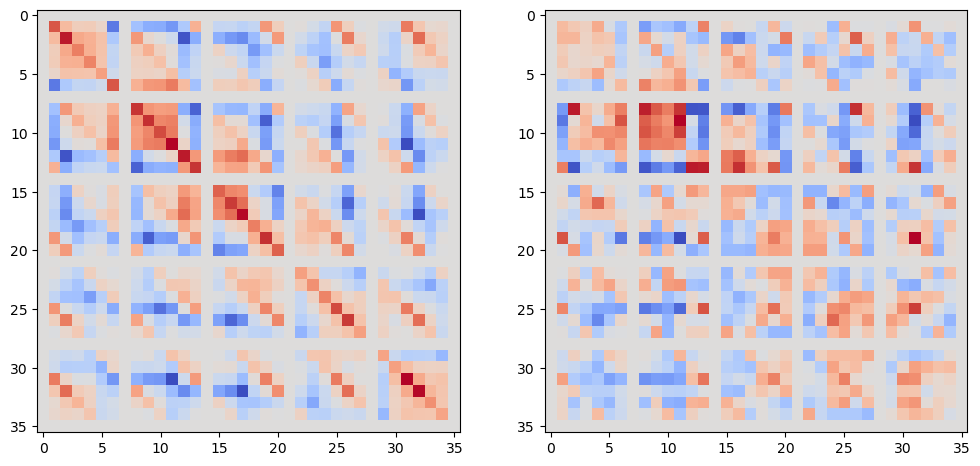

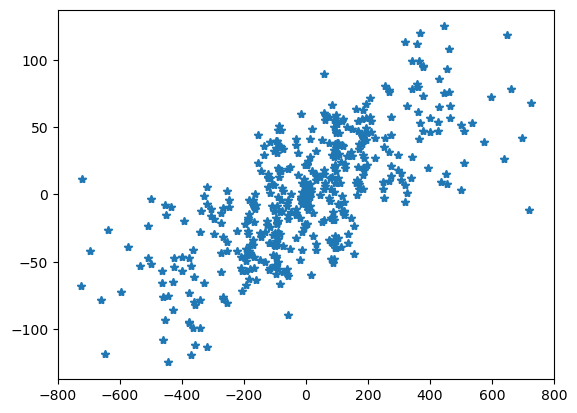

In [12]:
# Create a subspace alignment metric by measuring the correlation between the dot product matrices of the difference vectors
# Now try our new extraction scheme. Get difference vectors for all pairs of points
reg_tar = np.zeros([12, 30])
counter = 0
for q in range(6):
    for qp in range(6):
        if q != qp:
            reg_tar[q, counter] = 1
            reg_tar[6+qp,counter] = 1
            counter += 1

def create_difference_vectors(g_here):
    # Number of neurons x sequence element 1 x sequence element 2 x in which subspace
    difference_vectors = np.zeros([g_here.shape[0], 6, 6, 2])
    for q in range(6):
        for qp in range(6):
            for r in range(2):
                q_in_r = reg_tar[r*6 + q,:] == 1
                qp_in_r = reg_tar[r*6 + qp,:] == 1
                q_not_in_others = np.all((reg_tar[np.delete(np.arange(q, 2*6, 6), r),:] == 0), axis = 0)
                qp_not_in_others = np.all((reg_tar[np.delete(np.arange(qp, 2*6, 6), r),:] == 0), axis = 0)
                averaging_indices_q = np.all(np.vstack([q_in_r, qp_not_in_others, q_not_in_others]), axis = 0)
                averaging_indices_qp = np.all(np.vstack([qp_in_r, qp_not_in_others, q_not_in_others]), axis = 0)
    
                difference_vectors[:,q,qp,r] = np.mean(g_here[:, averaging_indices_q], axis = 1) - np.mean(g_here[:, averaging_indices_qp], axis = 1)

    return difference_vectors
    
def dot_mats(g_here):
    difference_vectors = create_difference_vectors(g_here)

    self_dot_mat = np.zeros([36, 36])
    across_dot_mat = np.zeros([36, 36])
    for theta1 in range(6):
        for theta2 in range(6):
            for theta1p in range(6):
                for theta2p in range(6):
                    self_dot_mat[theta1*6 + theta2, theta1p*6 + theta2p] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]
                    across_dot_mat[theta1*6 + theta2, theta1p*6 + theta2p] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]

    return self_dot_mat, across_dot_mat

self_dot_mat, across_dot_mat = dot_mats(full_avg_resp)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(self_dot_mat,cmap='coolwarm')

plt.subplot(1,2,2)
plt.imshow(across_dot_mat,cmap='coolwarm')

best_fitting_scale_parameter = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))
print(f'Best Fitting Scale Parameters: {best_fitting_scale_parameter}')

plt.figure()
plt.plot(np.ndarray.flatten(self_dot_mat), np.ndarray.flatten(across_dot_mat), '*')

In [11]:
# Create a neuron subsampled estimate of the same thing
random_samples = 100
best_fitting_scales = np.zeros(random_samples)

for n in range(random_samples):
    sub_sampled_neuron_inds = np.random.choice(num_neurons_full, int(num_neurons_full/2), replace = False)
    self_dot_mat, across_dot_mat = dot_mats(full_avg_resp[sub_sampled_neuron_inds,:])
    best_fitting_scales[n] = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))

print(f'Mean: {np.mean(best_fitting_scales)}, std: {np.std(best_fitting_scales)}')

Mean: 0.1234156138075723, std: 0.020330062670703242


In [15]:
# Create a plot like the ones from the paper

difference_vectors = create_difference_vectors(full_avg_resp)
difference_vectors.shape

(1220, 6, 6, 2)

In [22]:
def get_2_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    #print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:num_eigs]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]])

def mean_angles(thetas):
    thetas = thetas/180*np.pi
    x = np.mean(np.cos(thetas))
    y = np.mean(np.sin(thetas))
    return np.arctan2(y, x)/np.pi*180
    

Subspace Angles: [[79.39869388 87.65448844]]
83.52659116153607


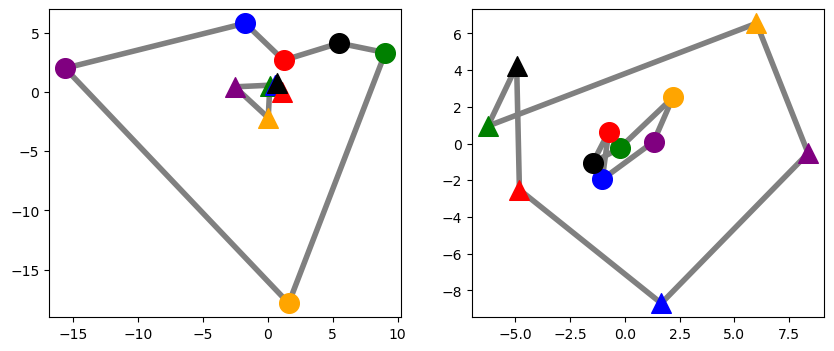

In [24]:
def difference_analysis(g_analysis, reg_tar, seq_len, num_stim, num_eigs = 2, fig = True):
    N = g_analysis.shape[0]
    
    # Now try our new extraction scheme. Get difference vectors for all pairs of points
    difference_vectors = np.zeros([N, num_stim, num_stim, seq_len])
    for q in range(num_stim):
        for qp in range(num_stim):
            for r in range(seq_len):
                q_in_r = reg_tar[r*num_stim + q,:] == 1
                qp_in_r = reg_tar[r*num_stim + qp,:] == 1
                q_not_in_others = np.all((reg_tar[np.delete(np.arange(q, seq_len*num_stim, num_stim), r),:] == 0), axis = 0)
                qp_not_in_others = np.all((reg_tar[np.delete(np.arange(qp, seq_len*num_stim, num_stim), r),:] == 0), axis = 0)
                averaging_indices_q = np.all(np.vstack([q_in_r, qp_not_in_others, q_not_in_others]), axis = 0)
                averaging_indices_qp = np.all(np.vstack([qp_in_r, qp_not_in_others, q_not_in_others]), axis = 0)
    
                difference_vectors[:,q,qp,r] = np.mean(g_analysis[:, averaging_indices_q], axis = 1) - np.mean(g_analysis[:, averaging_indices_qp], axis = 1)
        
    # Now extract a couple of PCs and calculate the angles between them?
    PCs = np.zeros([N, num_eigs, seq_len])
    for r in range(seq_len):
        difference_vectors_flat = np.zeros([N, int(num_stim*(num_stim-1)/2)])
        counter = 0
        for q in range(num_stim):
            for qp in range(q):
                difference_vectors_flat[:,counter] = difference_vectors[:,q,qp,r]
                counter += 1
        PCs[:,:,r] = get_2_PCs(difference_vectors_flat, num_eigs = num_eigs)
    
    # Let's get the subspace angles
    subspace_angles = np.zeros([int((seq_len-1)*seq_len/2), num_eigs])
    counter = 0
    for r in range(seq_len):
        for r_p in range(r):
            dot_prod = PCs[:,:,r].T@PCs[:,:,r_p]
            U, S, V = np.linalg.svd(dot_prod)
            try:
                subspace_angles[counter, :] = np.arccos(S)/np.pi*180
            except:
                subspace_angles[counter,:] = S
            counter += 1

    # Finally, let's reconstruct the activity from these difference vectors
    g_encodings = np.zeros([N, num_stim, seq_len])
    projections = np.zeros([num_eigs, num_stim, seq_len, seq_len])
    for seq_ind in range(seq_len):
        g_encodings[:,:,seq_ind] = difference_vectors[:,0,:,seq_ind] - np.mean(difference_vectors[:,0,:,seq_ind],axis = 1)[:,None]

    for seq_ind in range(seq_len):
        for seq_indp in range(seq_len):
            projections[:,:,seq_ind, seq_indp] = PCs[:,:,seq_ind].T@g_encodings[:,:,seq_indp]

    if fig:
        markers = ['o', '^']
        colours = ['green', 'orange', 'purple', 'blue','red','black']
    
        if num_eigs%2 == 0:
            plot_3D = 0
        else:
            plot_3D = 1
        plot_rows = int(np.floor(num_eigs/2))
        
        fig = plt.figure(figsize = (10,4*plot_rows))
        for r in range(seq_len):
            for plot in range(plot_rows):
                if plot == plot_rows - 1 and plot_3D:
                    num = plot_rows*100 + seq_len*10 + r+1+plot*seq_len
                    ax = fig.add_subplot(num, projection='3d')
                    if plot == 0:
                        plt.title(f'Rank {r+1} Subspace')
    
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            ax.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], projections[2+2*plot,q,r,rp], s = 150, zorder=1, color = colours[q], marker = markers[rp])
                            ax.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[2+2*plot,q,r,rp], projections[2+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
    
                else:
                    plt.subplot(plot_rows,seq_len,r+1+plot*seq_len)
                    if plot == 0:
                        #plt.title(f'Rank {r+1} Subspace')
                        cfes = 0
                        
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            plt.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
                            plt.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], s = 200, zorder=1, color = colours[q], marker = markers[rp])

                    ax = plt.gca()
                    #ax.axis('off')
        print(f'Subspace Angles: {subspace_angles}')
    return subspace_angles, difference_vectors, g_encodings, projections

subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(full_avg_resp, reg_tar, 2, 6, num_eigs = 2)
print(mean_angles(subspace_angles))